In [1]:
!pip install pandas --quiet
!pip install torchtext --quiet

In [2]:
# We import some libraries to load the dataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#Change the path#
path = '/Users/bengieru/Desktop/NMA-DL/iSarcasm/iSarcasm_dataset/'
header_list = ["text", "label", 'source']
df_train_test = pd.read_csv(path + 'finaldata/train_test.csv', encoding = "utf-8", dtype = {'text':str, 'label':bool, 'source':int})
df_train_test.reset_index(drop=True, inplace=True)
del df_train_test['Unnamed: 0']
df_train_test = df_train_test.loc[df_train_test.text.apply(lambda x: not isinstance(x, (float, int)))]
df_train_test

,text,label,source
0,sorry sue mediweight advert look incredible go...,False,3
1,since fantasy individual time alive today,False,3
2,good time fun time grand old britannia,True,3
3,send light love impacted vegasshooting know lo...,False,3
4,another year closer death,False,3
...,...,...,...
3551,imagine going cost 600 pound travel university...,False,3
3552,people really tryna argue dont need soap sanitary,False,3
3553,relentless running game brink upsetting 7 know...,False,3
3554,whether get bed 645 715 always 731 kitchen clo...,False,3


In [4]:
# let's play with the lemmatized text to see how it's accuracy fairs
X = df_train_test.text.values
print(X.shape)
# Changes values from [0,4] to [0,1]
y = (df_train_test.label.values >= 1).astype(int)


# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

(3544,)


In [5]:
for s, l in zip(x_train_text[:5], y_train[:5]):
    print('{}: {}'.format(l, s))

0: people still care lot leaked file sold public seen 2 leaked file tortured victim still waiting see leak journalist exposing nsa whistleblower karen stewart
0: good
1: magic money tree nurse one mp convenient
1: next train sure identifies train tram 🤦 🏻 ‍ ♀ ️
0: prince phillip personally visit woman house apologise accident


In [6]:
tokenizer = get_tokenizer("basic_english")
print('Before Tokenize: ', x_train_text[4])
print('After Tokenize: ', tokenizer(x_train_text[4]))

Before Tokenize:  prince phillip personally visit woman house apologise accident
After Tokenize:  ['prince', 'phillip', 'personally', 'visit', 'woman', 'house', 'apologise', 'accident']


In [7]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/2835 [00:00<?, ?it/s]

  0%|          | 0/709 [00:00<?, ?it/s]

In [8]:
words = Counter()
for s in x_train_token:
    for w in s:
        words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:20])

Number of different Tokens in our Dataset: 8822
['n', 'like', 'get', 'im', 'one', 'day', 'time', 'love', 'people', 'year', 'good', 'dont', 'back', 'today', 'really', 'new', 'make', 'go', 'would', 'thing']


In [9]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
    accumulated += words[sorted_words[counter]]
    counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 35.34345953298572% most common words account for the 80.00538122624693% of the occurrences


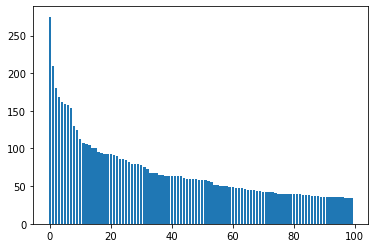

In [10]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

In [11]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [12]:
print('Before Vectorize: ', x_train_text[3])

Before Vectorize:  next train sure identifies train tram 🤦 🏻 ‍ ♀ ️


In [13]:
# Notice that the matriz is sparse
print('After Vectorize: ')
print(x_train_cv[3])

After Vectorize: 
  (0, 5091)	1
  (0, 7743)	1
  (0, 7356)	1
  (0, 3700)	1
  (0, 7749)	1


In [14]:
def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, if possible, in the menu under `Runtime` -> `Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

In [15]:
# Set the device (check if gpu is available)
device = set_device()
#First we will create a Dictionary (`word_to_idx`). 
#This dictionary will map each Token (usually words) to an index (an integer number). 
#We want to limit our dictionary to a certain number of tokens (`num_words_dict`), so we will include in our ditionary those with more occurrences.

In [16]:
#Change the path#
glove = pd.read_csv('/Users/bengieru/Downloads/glove/glove.twitter.27B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

In [17]:
len(sorted_words)

8822

In [18]:
#Let's select only the most used.
num_words_dict = 6000
# We reserve two numbers for special tokens.
most_used_words = sorted_words[:num_words_dict-2]


#We will add two extra Tokens to the dictionary, one for words outside the dictionary (`'UNK'`) and one for padding the sequences (`'PAD'`).

# dictionary to go from words to idx 
word_to_idx = {}
# dictionary to go from idx to words (just in case) 
idx_to_word = {}


# We include the special tokens first
PAD_token = 0   
UNK_token = 1

word_to_idx['PAD'] = PAD_token
word_to_idx['UNK'] = UNK_token

idx_to_word[PAD_token] = 'PAD'
idx_to_word[UNK_token] = 'UNK'

# We popullate our dictionaries with the most used words
for num,word in enumerate(most_used_words):
    word_to_idx[word] = num + 2
    idx_to_word[num+2] = word
    
    
def create_embedding_matrix(word_index,embedding_dict,dimension):
    embedding_matrix=np.zeros((len(word_index)+1,dimension))
 
    for word,index in word_index.items():
        if word in embedding_dict:
            embedding_matrix[index]=embedding_dict[word]
    return embedding_matrix


# My word_to_idx is the same as their word_index
embedding_matrix = create_embedding_matrix(word_to_idx, 
                                           embedding_dict = glove_embedding,
                                           dimension = 100)


#Our goal now is to transform each tweet from a sequence of tokens to a sequence of indexes. 
# These sequences of indexes will be the input to our pytorch model.

# A function to convert list of tokens to list of indexes
def tokens_to_idx(sentences_tokens,word_to_idx):
    sentences_idx = []
    for sent in sentences_tokens:
        sent_idx = []
        for word in sent:
            if word in word_to_idx:
                sent_idx.append(word_to_idx[word])
            else:
                sent_idx.append(word_to_idx['UNK'])
        sentences_idx.append(sent_idx)
    return sentences_idx

x_train_idx = tokens_to_idx(x_train_token, word_to_idx)
x_test_idx = tokens_to_idx(x_test_token, word_to_idx)



# We need all the sequences to have the same length. 
# To select an adequate sequence length, let's explore some statistics about the length of the tweets:
tweet_lens = np.asarray([len(sentence) for sentence in x_train_idx])
print('Max tweet word length: ',tweet_lens.max())
print('Mean tweet word length: ',np.median(tweet_lens))
print('99% percent under: ',np.quantile(tweet_lens,0.99))

Max tweet word length:  50
Mean tweet word length:  9.0
99% percent under:  29.0


In [19]:
#We cut the sequences which are larger than our chosen maximum length (`max_lenght`) and fill with zeros the ones that are shorter.
 # We choose the max length
max_length = 30

# A function to make all the sequence have the same lenght
# Note that the output is a Numpy matrix
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, tweet in enumerate(sentences):
        len_tweet = len(tweet) 
        if len_tweet != 0:
            if len_tweet <= seq_len:
        # If its shorter, we fill with zeros (the padding Token index)
                features[ii, -len(tweet):] = np.array(tweet)[:seq_len]
            if len_tweet > seq_len:
        # If its larger, we take the last 'seq_len' indexes
                features[ii, :] = np.array(tweet)[-seq_len:]
    return features

In [20]:
# We convert our list of tokens into a numpy matrix
# where all instances have the same lenght
x_train_pad = padding(x_train_idx,max_length)
x_test_pad = padding(x_test_idx,max_length)

# We convert our target list a numpy matrix
y_train_np = np.asarray(y_train)
y_test_np = np.asarray(y_test)

In [21]:
some_number = 2
print('Before padding: ', x_train_idx[some_number])
print('After padding: ', x_train_pad[some_number])

Before padding:  [1540, 109, 831, 3367, 6, 2102, 3368]
After padding:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0 1540  109  831 3367    6
 2102 3368]


In [22]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train_np))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test_np))

# Batch size (this is an important hyperparameter)
batch_size = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last = True)

In [23]:
x_train_pad.shape, x_test_pad.shape, y_train_np.shape, y_test_np.shape

((2835, 30), (709, 30), (2835,), (709,))

In [24]:
# Obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 30])
Sample input: 
 tensor([[   0,    0,    0,  ...,  183,    6,  136],
        [   0,    0,    0,  ..., 1515,  102, 1662],
        [   0,    0,    0,  ...,  360,    1, 1096],
        ...,
        [   0,    0,    0,  ...,    1,   89,    1],
        [   0,    0,    0,  ...,  237,  457, 1043],
        [   0,    0,    0,  ..., 1978,    1,  153]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0])


Now, we will define the `SentimentRNN` class. Most of the model's class will be familiar to you, but there are two important layers we would like you to pay attention to:

*   Embedding Layer
> This layer is like a linear layer, but it makes it posible to use a sequence of inedexes as inputs (instead of a sequence of one-hot-encoded vectors). During training, the Embedding layer learns a linear transformation from the space of words (a vector space of dimension `num_words_dict`) into the a new, smaller, vector space of dimension `embedding_dim`. We suggest you to read this [thread](https://discuss.pytorch.org/t/how-does-nn-embedding-work/88518/3) and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) if you want to learn more about this particular kind of layers.


*   LSTM layer
> This is one of the most used class of Recurrent Neural Networks. In Pytorch we can add several stacked layers in just one line of code. In our case, the number of layers added are decided with the parameter `no_layers`. If you want to learn more about LSTMs we strongly recommend you this [Colahs thread](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) about them.








SentimentLSTM(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  675941
SentimentLSTM(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  742501
SentimentLSTM(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=8, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  875621
CPU times: user 3min 57s, sys: 1min 7s, total: 5min 5s
Wall time: 3min 46s


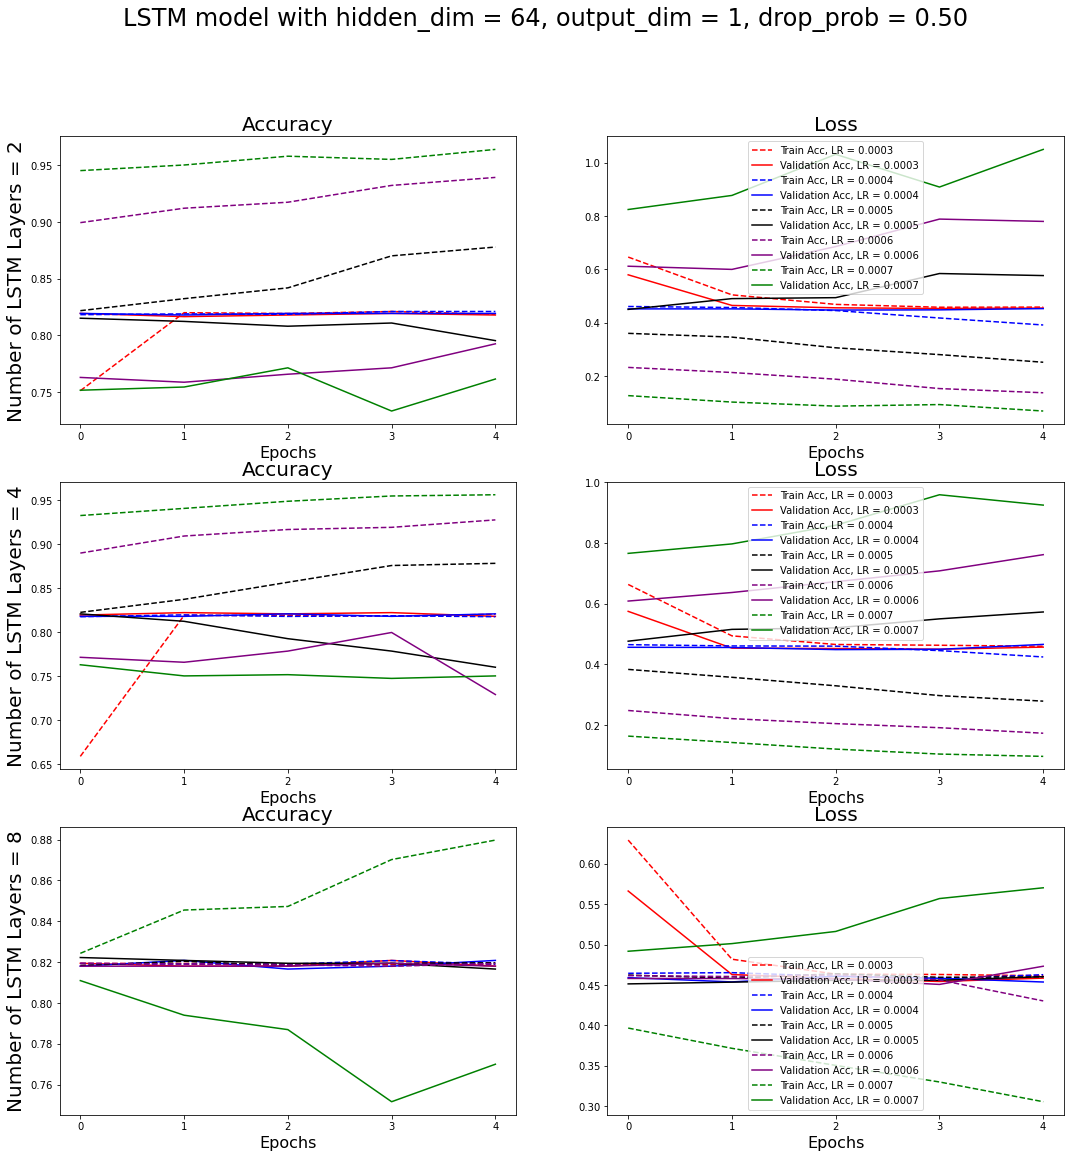

In [25]:
%%time
# Let us a LSTM RNN using the pre-trianed embedding from GLOVE.
class SentimentLSTM(nn.Module):
    def __init__(self, no_layers, hidden_dim, embedding_matrix, drop_prob=0.1):
        super(SentimentLSTM,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.drop_prob = drop_prob
        self.vocab_size = embedding_matrix.shape[0]
        self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding Layer
        self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=True
    
    # LSTM Layers
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, bidirectional=False, batch_first=True, 
                            dropout=self.drop_prob)

    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
    
        batch_size = x.size(0)
    
        embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]
    
    # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]
    
    # Select the activation of the last Hidden Layer
        lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

    # Sigmoid function
        sig_out = self.sig(out)

    # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

#######################################################################################
# Parameters of our network
# Size of our vocabulary
# Number of stacked LSTM layers
no_layerss = [2, 4, 8]
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.5

# Let's define our model
fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('LSTM model with hidden_dim = %d, output_dim = %d, drop_prob = %.2f'%(hidden_dim, output_dim, drop_prob), fontsize = 24)
for no, no_layers in enumerate(no_layerss):
    model = SentimentLSTM(no_layers, 
                          hidden_dim, 
                          embedding_matrix, 
                          drop_prob = drop_prob)
# Moving to gpu
    model.to(device)
    print(model)

#######################################################################################
# How many trainable parameters does our model have?
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total Number of parameters: ',params)

#######################################################################################
# loss and optimization functions
    lrs = np.linspace(0.0003, 0.0007, 5)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
    criterion = nn.BCELoss()

# We choose an Adam optimizer
    optimizers = []
    for i,lr in enumerate(lrs):
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        optimizers.append(optimizer)

#######################################################################################
# function to predict accuracy
    def acc(pred,label):
        pred = torch.round(pred.squeeze())
        return torch.sum(pred == label.squeeze()).item()

#######################################################################################
# Number of training Epochs
    epochs = 5

# Maximum absolute value accepted for the gradeint
    clip = 5

# Initial Loss value (assumed big)
    valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
    epoch_tr_loss, epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
    epoch_tr_acc, epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
    for i, lr in enumerate(lrs):
        for epoch in range(epochs):
            train_losses = []
            train_acc = 0.0
            model.train()
  
            for inputs, labels in train_loader:

    # Initialize hidden state 
                h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
                h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
                model.zero_grad()

    # Compute model output
                output,h = model(inputs,h)

    # Calculate the loss and perform backprop
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                train_losses.append(loss.item())

    # calculating accuracy
                accuracy = acc(output,labels)
                train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizers[i].step()

  
  # Evaluate on the validation set for this epoch 
            val_losses = []
            val_acc = 0.0
            model.eval()
            for inputs, labels in valid_loader:

    # Initialize hidden state 
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
                output, val_h = model(inputs, val_h)

    # Compute Loss
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                val_acc += accuracy
          
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_loader.dataset)
            epoch_val_acc = val_acc/len(valid_loader.dataset)
            epoch_tr_loss[i].append(epoch_train_loss)
            epoch_vl_loss[i].append(epoch_val_loss)
            epoch_tr_acc[i].append(epoch_train_acc)
            epoch_vl_acc[i].append(epoch_val_acc)
            #print(f'Epoch {epoch+1}') 
            #print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            #print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
            if epoch_val_loss <= valid_loss_min:
                #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
                valid_loss_min = epoch_val_loss
            #print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
#fig,ax = plt.subplots(3,2, figsize = 60,20)
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([0,1,2,3,4])
    ax[no][0].set_ylabel('Number of LSTM Layers = %d'%no_layers, fontsize = 20)
    #ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([0,1,2,3,4])
    #ax[no][1].set_ylabel('Number of Layers = %d'%no_layers, fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
#plt.tight_layout()

SentimentGRU(
  (embedding): Embedding(6001, 100)
  (gru): GRU(100, 64, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  656997
SentimentGRU(
  (embedding): Embedding(6001, 100)
  (gru): GRU(100, 64, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  706917
SentimentGRU(
  (embedding): Embedding(6001, 100)
  (gru): GRU(100, 64, num_layers=8, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  806757
CPU times: user 3min 27s, sys: 1min 11s, total: 4min 38s
Wall time: 3min 18s


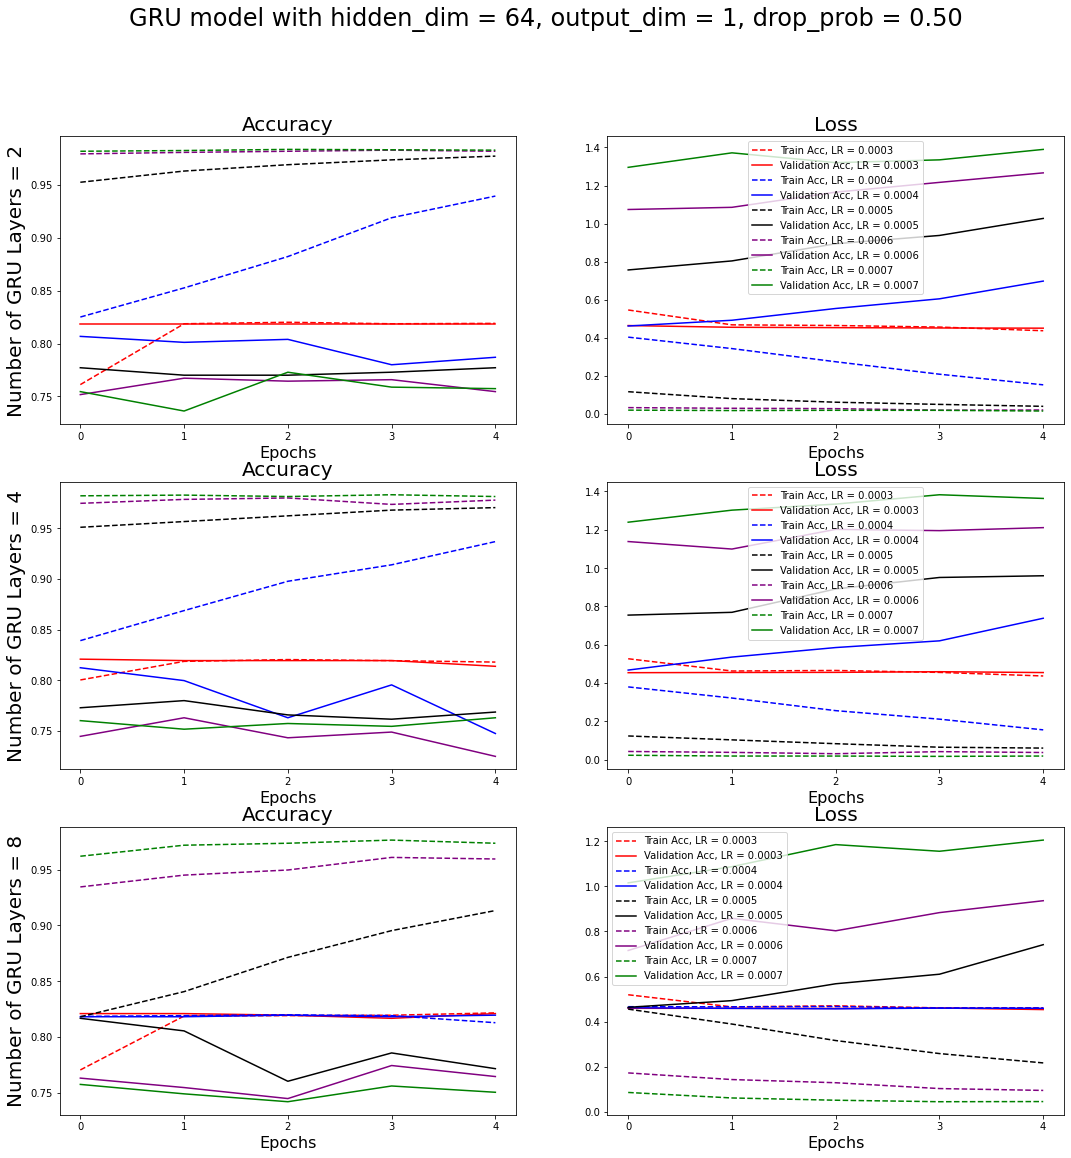

In [26]:
%%time
class SentimentGRU(nn.Module):
    def __init__(self, no_layers, hidden_dim, embedding_matrix, drop_prob = 0.01):
        super(SentimentGRU, self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.drop_prob = drop_prob
        self.vocab_size = embedding_matrix.shape[0]
        self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding layer
        self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=True

    # GRU Layers
        self.gru = nn.GRU(input_size= self.embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, bidirectional=False, batch_first=True, 
                            dropout=self.drop_prob)

    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
        batch_size = x.size(0)
        self.h = self.init_hidden(batch_size)
    
    # Embedding out
        embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]

    # GRU out
        gru_out, self.h = self.gru(embeds, self.h)
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
        gru_out = gru_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    # Dropout and Fully connected layer
        out = self.dropout(gru_out)
        out = self.fc(out)

    # Sigmoid function
        sig_out = self.sig(out)

    # return last sigmoid output and hidden state
        return sig_out

    def init_hidden(self, batch_size):
        hidden = (torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device))
        return hidden

#######################################################################################
# Parameters of our network
# Size of our vocabulary
# Number of stacked LSTM layers
no_layerss = [2, 4, 8]
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.5

# Let's define our model
fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('GRU model with hidden_dim = %d, output_dim = %d, drop_prob = %.2f'%(hidden_dim, output_dim, drop_prob), fontsize = 24)
for no, no_layers in enumerate(no_layerss):
    model = SentimentGRU(no_layers, 
                         hidden_dim,
                         embedding_matrix, 
                         drop_prob = drop_prob)
# Moving to gpu
    model.to(device)
    print(model)

# How many trainable parameters does our model have?
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total Number of parameters: ',params)

#######################################################################################
# loss and optimization functions
    lrs = np.linspace(0.0003, 0.0007, 5) #define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
    criterion = nn.BCELoss()

# We choose an Adam optimizer
    optimizers = []
    for i,lr in enumerate(lrs):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        optimizers.append(optimizer)

#######################################################################################
# function to predict accuracy
    def acc(pred,label):
        pred = torch.round(pred.squeeze())
        return torch.sum(pred == label.squeeze()).item()

#######################################################################################
#######################################################################################
# Number of training Epochs
    epochs = 5

# Maximum absolute value accepted for the gradeint
    clip = 5

# Initial Loss value (assumed big)
    valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
    epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
    epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
    for i, lr in enumerate(lrs):
        for epoch in range(epochs):
            train_losses = []
            train_acc = 0.0
            model.train()
  
            for inputs, labels in train_loader:

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
                model.zero_grad()

    # Compute model output
                output = model(inputs,h)

    # Calculate the loss and perform backprop
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                train_losses.append(loss.item())

    # calculating accuracy
                accuracy = acc(output,labels)
                train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

  
  # Evaluate on the validation set for this epoch 
            val_losses = []
            val_acc = 0.0
            model.eval()
            for inputs, labels in valid_loader:

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
                output = model(inputs, val_h)

    # Compute Loss
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                val_acc += accuracy
          
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_loader.dataset)
            epoch_val_acc = val_acc/len(valid_loader.dataset)
            epoch_tr_loss[i].append(epoch_train_loss)
            epoch_vl_loss[i].append(epoch_val_loss)
            epoch_tr_acc[i].append(epoch_train_acc)
            epoch_vl_acc[i].append(epoch_val_acc)
            #print(f'Epoch {epoch+1}') 
            #print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            #print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
            if epoch_val_loss <= valid_loss_min:
                #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
                valid_loss_min = epoch_val_loss
            #print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
#fig,ax = plt.subplots(3,2, figsize = 60,20)
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([0,1,2,3,4])
    ax[no][0].set_ylabel('Number of GRU Layers = %d'%no_layers, fontsize = 20)
    #ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([0,1,2,3,4])
    #ax[no][1].set_ylabel('Number of Layers = %d'%no_layers, fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
#plt.tight_layout()

SentimentLSTM_bi(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  784549
SentimentLSTM_bi(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=4, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  983205
SentimentLSTM_bi(
  (embedding): Embedding(6001, 100)
  (lstm): LSTM(100, 64, num_layers=8, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)
Total Number of parameters:  1380517
CPU times: user 8min 44s, sys: 2min 32s, total: 11min 17s
Wall time: 8min 34s


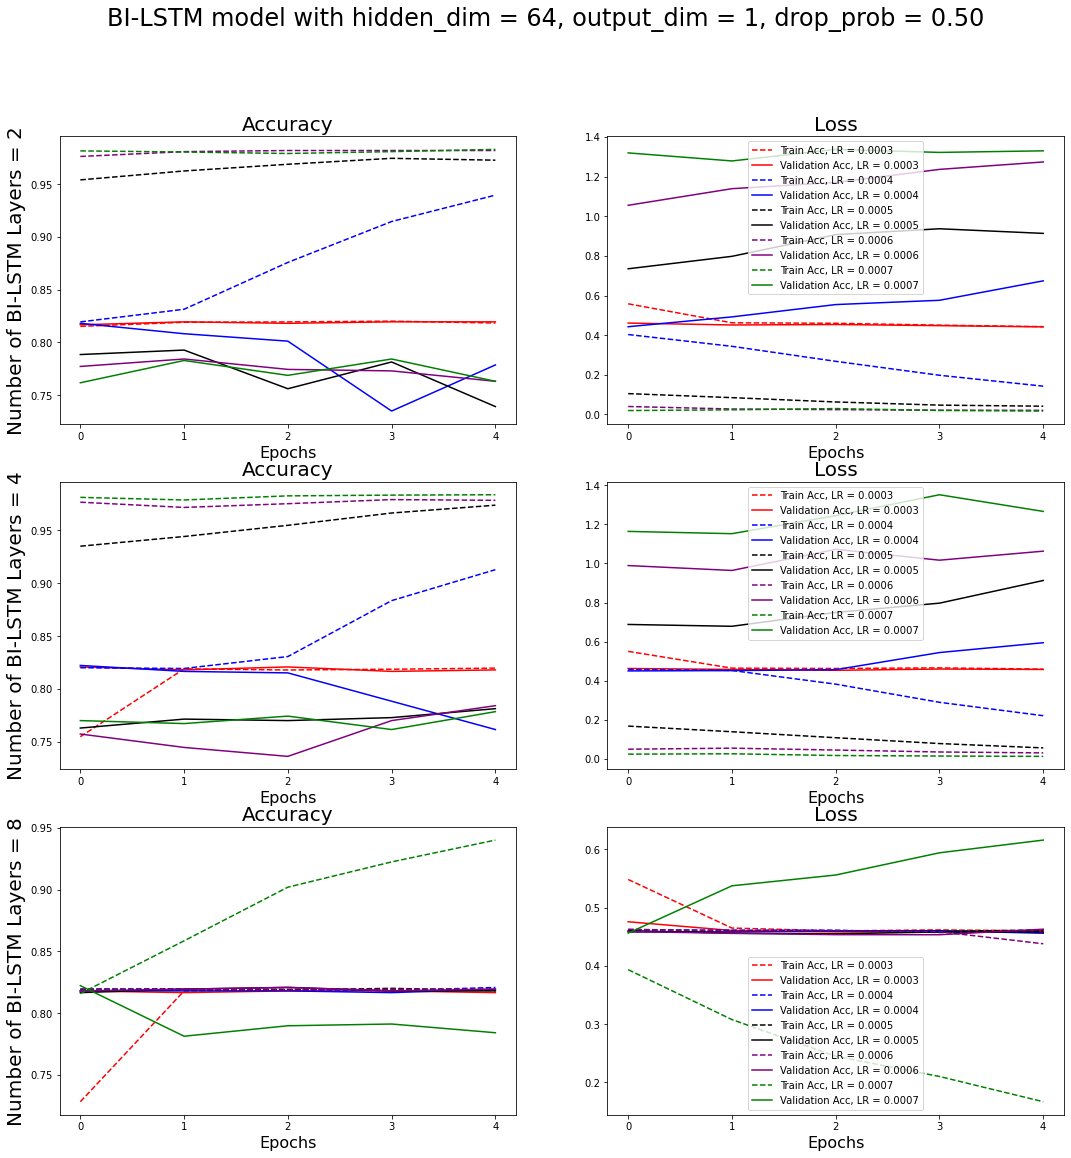

In [27]:
%%time
class SentimentLSTM_bi(nn.Module):
    def __init__(self,no_layers,hidden_dim,embedding_matrix,drop_prob=0.1):
        super(SentimentLSTM_bi,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.no_layers = no_layers
        self.drop_prob = drop_prob
        self.vocab_size = embedding_matrix.shape[0]
        self.embedding_dim = embedding_matrix.shape[1]
    
    # Embedding Layer
        self.embedding=nn.Embedding(self.vocab_size,self.embedding_dim)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=True

    # LSTM Layers
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_dim,
                            num_layers=no_layers, bidirectional=True, batch_first=True, 
                            dropout=self.drop_prob)
    
    # Dropout layer
        self.dropout = nn.Dropout(drop_prob)

    # Linear and Sigmoid layer
        self.fc = nn.Linear(self.hidden_dim * 2, output_dim)
        self.sig = nn.Sigmoid()
      
    def forward(self,x,hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
    #Shape: [batch_size x max_length x embedding_dim]
    
    # LSTM out
        lstm_out, hidden = self.lstm(embeds, hidden)
    # Shape: [batch_size x max_length x hidden_dim]
    
    # Select the activation of the last Hidden Layer
        lstm_out = lstm_out[:,-1,:].contiguous()
    # Shape: [batch_size x hidden_dim]

    ## You can instead average the activations across all the times
    # lstm_out = torch.mean(lstm_out, 1).contiguous()

    # Dropout and Fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

    # Sigmoid function
        sig_out = self.sig(out)

    # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers * 2,batch_size, self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers * 2,batch_size, self.hidden_dim)).to(device)
    
        hidden = (h0,c0)
        return hidden
    
#######################################################################################
# Parameters of our network
# Size of our vocabulary
# Number of stacked LSTM layers
no_layerss = [2, 4, 8]
# Dimension of the hidden layer in LSTMs
hidden_dim = 64
# Dropout parameter for regularization
output_dim = 1
# Dropout parameter for regularization
drop_prob = 0.5

# Let's define our model
fig,ax = plt.subplots(3,2, figsize = (18, 18))
fig.suptitle('BI-LSTM model with hidden_dim = %d, output_dim = %d, drop_prob = %.2f'%(hidden_dim, output_dim, drop_prob), fontsize = 24)
for no, no_layers in enumerate(no_layerss):
    model = SentimentLSTM_bi(no_layers, 
                             hidden_dim, 
                             embedding_matrix, 
                             drop_prob = drop_prob)
# Moving to gpu
    model.to(device)
    print(model)

#######################################################################################
# How many trainable parameters does our model have?
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print('Total Number of parameters: ',params)

#######################################################################################
# loss and optimization functions
    lrs = np.linspace(0.0003, 0.0007, 5)#define a range of learning rates

# Binary crossentropy is a good loss function for a binary classification problem
    criterion = nn.BCELoss()

# We choose an Adam optimizer
    optimizers = []
    for i,lr in enumerate(lrs):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        optimizers.append(optimizer)

#######################################################################################
# function to predict accuracy
    def acc(pred,label):
        pred = torch.round(pred.squeeze())
        return torch.sum(pred == label.squeeze()).item()

#######################################################################################
#######################################################################################
# Number of training Epochs
    epochs = 5

# Maximum absolute value accepted for the gradeint
    clip = 5

# Initial Loss value (assumed big)
    valid_loss_min = np.Inf

# Lists to follow the evolution of the loss and accuracy
    epoch_tr_loss,epoch_vl_loss = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]
    epoch_tr_acc,epoch_vl_acc = [[] for i in range(len(lrs))],[[] for i in range(len(lrs))]

# Train for a number of Epochs
    for i, lr in enumerate(lrs):
        for epoch in range(epochs):
            train_losses = []
            train_acc = 0.0
            model.train()
  
            for inputs, labels in train_loader:

    # Initialize hidden state 
                h = model.init_hidden(batch_size)
    # Creating new variables for the hidden state
                h = tuple([each.data.to(device) for each in h])

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)   

    # Set gradient to zero
                model.zero_grad()

    # Compute model output
                output,h = model(inputs,h)

    # Calculate the loss and perform backprop
                loss = criterion(output.squeeze(), labels.float())
                loss.backward()
                train_losses.append(loss.item())

    # calculating accuracy
                accuracy = acc(output,labels)
                train_acc += accuracy

    #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
                nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()

  
  # Evaluate on the validation set for this epoch 
            val_losses = []
            val_acc = 0.0
            model.eval()
            for inputs, labels in valid_loader:

    # Initialize hidden state 
                val_h = model.init_hidden(batch_size)
                val_h = tuple([each.data.to(device) for each in val_h])

    # Move batch inputs and labels to gpu
                inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
                output, val_h = model(inputs, val_h)

    # Compute Loss
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

                accuracy = acc(output,labels)
                val_acc += accuracy
          
            epoch_train_loss = np.mean(train_losses)
            epoch_val_loss = np.mean(val_losses)
            epoch_train_acc = train_acc/len(train_loader.dataset)
            epoch_val_acc = val_acc/len(valid_loader.dataset)
            epoch_tr_loss[i].append(epoch_train_loss)
            epoch_vl_loss[i].append(epoch_val_loss)
            epoch_tr_acc[i].append(epoch_train_acc)
            epoch_vl_acc[i].append(epoch_val_acc)
            #print(f'Epoch {epoch+1}') 
            #print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
            #print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
            if epoch_val_loss <= valid_loss_min:
             #   print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    # torch.save(model.state_dict(), '../working/state_dict.pt')
                valid_loss_min = epoch_val_loss
            #print(25*'==')

#######################################################################################
# plot the results from the training and validation accuracies
#fig,ax = plt.subplots(3,2, figsize = 60,20)
    colors = ['red', 'blue', 'black', 'purple', 'green', 'brown']
    for i,e in enumerate(lrs):
        ax[no][0].plot(epoch_tr_acc[i], linestyle = '--', color = colors[i], label = 'Train Acc, LR = %.4f'%e)
        ax[no][0].plot(epoch_vl_acc[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
# plt.ylim([70, 80])
    ax[no][0].set_title("Accuracy", fontsize = 20)
    ax[no][0].set_xlabel('Epochs', fontsize = 16)
    ax[no][0].set_xticks([0,1,2,3,4])
    ax[no][0].set_ylabel('Number of BI-LSTM Layers = %d'%no_layers, fontsize = 20)
    #ax[no][0].legend(prop = dict(size = 12))

    for i,e in enumerate(lrs):
        ax[no][1].plot(epoch_tr_loss[i], color = colors[i], linestyle = '--', label = 'Train Acc, LR = %.4f'%e)
        ax[no][1].plot(epoch_vl_loss[i], color = colors[i], label = 'Validation Acc, LR = %.4f'%e)
    ax[no][1].set_title("Loss", fontsize = 20)
    ax[no][1].set_xlabel('Epochs', fontsize = 16)
    ax[no][1].set_xticks([0,1,2,3,4])
    #ax[no][1].set_ylabel('Number of Layers = %d'%no_layers, fontsize = 20)
    ax[no][1].legend(prop = dict(size = 10))
#plt.tight_layout()